In [1]:
model = "disa"  # "disa" or "sa"
if model == "disa":
    from models.disa import *
elif model == "sa":
    from models.sa import *

import matplotlib.pyplot as plt
from dataset import *
from torchvision import transforms

device = torch.device("cuda")

In [2]:
dataset = "clevr"  # "tetr", "mds", or "clevr"

if dataset == "tetr":
    test_set = Dataset("tetrominoes", "data/tetrominoes/", "test", noise=False, crop=False, resize=False, proppred=False)
    num_slots = 4
    num_iterations = 3
    slots_dim = 64 if model == "sa" else 32
    resolution = (35, 35)
    encdec_dim = 32 
    smallarch = True
elif dataset == "mds":
    test_set = Dataset("multidsprites", "data/multidsprites/", "test", noise=False, crop=False, resize=False, proppred=False)
    num_slots = 6
    num_iterations = 3
    slots_dim = 64 if model == "sa" else 32
    resolution = (64, 64)
    encdec_dim = 32 
    smallarch = True
elif dataset == "clevr":
    test_set = Dataset("clevr", "data/clevr6/", "test", noise=False, crop="center", resize=True, proppred=False)
    num_slots = 7
    num_iterations = 3
    slots_dim = 64 if model == "sa" else 32
    resolution = (128, 128)
    encdec_dim = 64
    smallarch = False

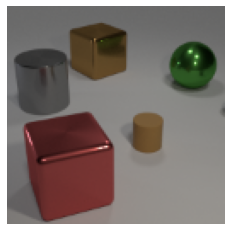

In [3]:
sample_idx = 4
sample = test_set.__getitem__(sample_idx)
image = sample["image"].unsqueeze(0).to(device)
masks = sample["mask"].unsqueeze(0).to(device)
plt.grid(False); plt.axis("off")
plt.imshow(image.squeeze(0).cpu().permute((1,2,0)))

In [16]:
if model == "sa":
    model = SlotAttentionAutoEncoder(resolution, num_slots, num_iterations, slots_dim, encdec_dim, smallarch, learned_slots=False).to(device)
    model.eval()
    model.encoder_cnn.encoder_pos.grid = model.encoder_cnn.encoder_pos.grid.to(device)  # model.to(device) do not move
    model.decoder_cnn.decoder_pos.grid = model.decoder_cnn.decoder_pos.grid.to(device)  # these tensors automatically
    if dataset == "tetr":
        ckpt = "checkpoints/tetrominoes/tetr_sa_106ep.ckpt"
    elif dataset == "mds":
        ckpt = "checkpoints/multidsprites/mds_sa_266ep.ckpt"
    elif dataset == "clevr":
        ckpt = "checkpoints/clevr6/clevr6_sa_crop_273ep.ckpt"
    model.load_state_dict(torch.load(ckpt, map_location=device)["model_state_dict"], strict=True)
    texturestruction, textures, masks, slots, attn = model(image)
elif model == "disa":
    model = DISA(resolution, num_slots, num_iterations, slots_dim, encdec_dim, smallarch, learned_slots=True, bilevel=True, learned_factors=True, scale_inv=True).to(device)
    model.eval()
    model.slot_attention.pos_emb.grid = model.slot_attention.pos_emb.grid.to(device)
    model.enc_pos_emb.grid = model.enc_pos_emb.grid.to(device)
    model.dec_pos_emb.grid = model.dec_pos_emb.grid.to(device)
    if dataset == "tetr":
        ckpt = "checkpoints/tetrominoes/tetr_disa_run2_106ep.ckpt"
    elif dataset == "mds":
        ckpt = "checkpoints/multidsprites/mds_disa_266ep.ckpt"
    elif dataset == "clevr":
        ckpt = "checkpoints/clevr6/clevr6_disa_243ep.ckpt"
    model.load_state_dict(torch.load(ckpt, map_location=device)['model_state_dict'], strict=True)
    reconstruction, textures, masks, slots, edge_mask, attn = model(image)

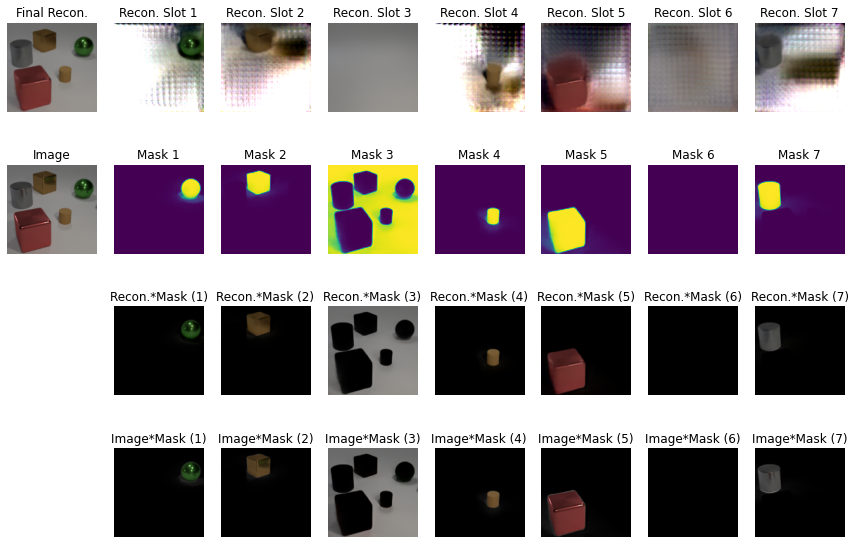

In [12]:
def visualize(image, reconstruction, textures, masks):
    fig, ax = plt.subplots(4, num_slots + 1, figsize=(15, 10))
    ax[0][0].imshow(reconstruction.squeeze(0).permute((1,2,0)).detach().cpu().clip(0.,1.))
    ax[0][0].set_title('Final Recon.')
    ax[1][0].imshow(image.squeeze(0).cpu().permute((1,2,0)))
    ax[1][0].set_title('Image')
    for i in range(num_slots):
        texture = textures.squeeze(0)[i].detach().cpu()
        mask = masks.squeeze(0)[i].detach().cpu()
        ax[0][i + 1].imshow(texture, vmin=0., vmax=1.)
        ax[0][i + 1].set_title('Recon. Slot %s' % str(i + 1))
        ax[1][i + 1].imshow(mask, vmin=0., vmax=1.)
        ax[1][i + 1].set_title('Mask %s' % str(i + 1))
        ax[2][i + 1].imshow(texture*mask, vmin=0., vmax=1.)
        ax[2][i + 1].set_title('Recon.*Mask (%s)' % str(i + 1))
        ax[3][i + 1].imshow(image.squeeze(0).permute(1,2,0).cpu()*mask, vmin=0., vmax=1.)
        ax[3][i + 1].set_title('Image*Mask (%s)' % str(i + 1))
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            ax[i][j].grid(False)
            ax[i][j].axis('off')
    plt.rcParams["svg.fonttype"] = "none"
    # fig.savefig("comp.svg")

reconstruction, textures, masks, slots, edge_mask, attn = model(image)
visualize(image, reconstruction, textures, masks)

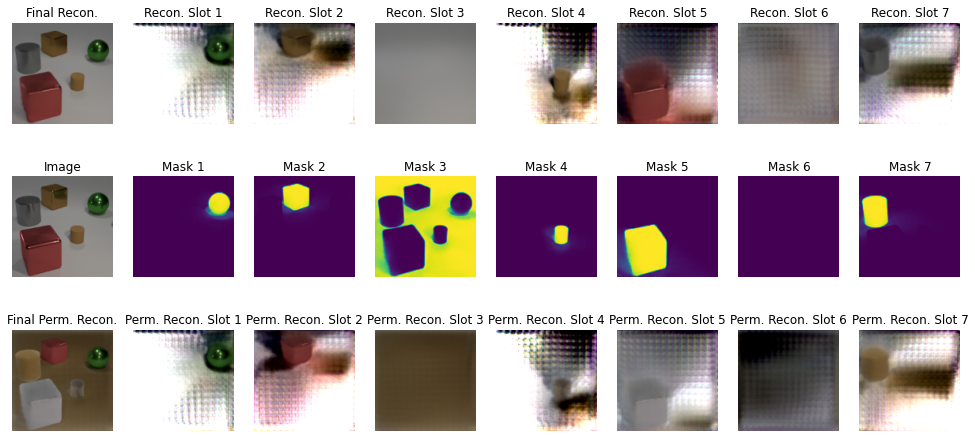

In [15]:
def visualize_perm(image, reconstruction, textures, masks, reconstruction_, textures_):
    fig, ax = plt.subplots(3, num_slots + 1, figsize=(17, 8))
    ax[0][0].imshow(reconstruction.squeeze(0).permute((1,2,0)).detach().cpu().clip(0.,1.))
    ax[0][0].set_title('Final Recon.')
    ax[1][0].imshow(image.squeeze(0).cpu().permute((1,2,0)))
    ax[1][0].set_title('Image')
    ax[2][0].imshow(reconstruction_.squeeze(0).permute((1,2,0)).detach().cpu().clip(0.,1.))
    ax[2][0].set_title('Final Perm. Recon.')
    for i in range(num_slots):
        texture = textures.squeeze(0)[i].detach().cpu().clip(0.,1.)
        ax[0][i + 1].imshow(texture, vmin=0., vmax=1.)
        ax[0][i + 1].set_title('Recon. Slot %s' % str(i + 1))
        ax[1][i + 1].imshow(masks.squeeze(0)[i].detach().cpu(), vmin=0., vmax=1.)
        ax[1][i + 1].set_title('Mask %s' % str(i + 1))
        texture = textures_.squeeze(0)[i].detach().cpu().clip(0.,1.)
        ax[2][i + 1].imshow(texture, vmin=0., vmax=1.)
        ax[2][i + 1].set_title('Perm. Recon. Slot %s' % str(i + 1))
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            ax[i][j].grid(False)
            ax[i][j].axis('off')
    plt.rcParams["svg.fonttype"] = "none"
    # fig.savefig("comp.svg")

reconstruction, textures, masks, slots, edge_mask, attn = model(image)
s_pos, s_scale = slots[:, :, -4:-2].unsqueeze(2).unsqueeze(2), slots[:, :, -2:].unsqueeze(2).unsqueeze(2)
slots = slots[:, :, :-4]
# s_pos[:,0,:,:,0] -= 0.25
# s_scale[:,0,:,:,0] += 0.05

# permute textures
perm_ind = torch.randperm(slots.shape[1])
# perm_ind = torch.tensor([0,0,2,0,0,6,1])
slots_texture = slots[:, perm_ind, :slots_dim]
slots_mask = slots[:, :, slots_dim:]
# slots_texture[:,:,:] += 0.3 * torch.randn(slots_texture[:,:,:].shape).to(device)
# slots_mask[:,:,:] += 0.3 * torch.randn(slots_mask[:,:,:].shape).to(device)
slots = torch.concat([slots_texture, slots_mask], dim=-1)
reconstruction_, textures_, masks_ = model.decode(slots, s_pos, s_scale)

visualize_perm(image, reconstruction, textures, masks, reconstruction_, textures_)